<a href="https://colab.research.google.com/github/adihebbalae/adihebbalae-MusicRecommenders/blob/main/Section2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import ast
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from IPython import display
import ipywidgets as widgets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

# music_data_url = 'https://drive.google.com/uc?id=1Q4UAv4FPPOlhmFWHkn4Y83dG6M51xnoM'
!wget 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Music%20Recommendation/data_with_most_lyrics.csv'
music_data_path = './data_with_most_lyrics.csv'
# gdown.download(music_data_url, music_data_path, True)

music_data = pd.read_csv(music_data_path)
music_data = music_data.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.2'])
music_data['lyrics'] = music_data['lyrics'].str.replace('\n', ' ')
available_songs = music_data["track_name"] + ', ' + music_data["artist_name"]
available_songs = available_songs.tolist()


# past_data_url = 'https://drive.google.com/uc?id=1MIkOcP2JY_foloYAR5-Y60YyRVbRhQMs'
!wget 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Music%20Recommendation/spotify_data_urls.csv'
past_data_path = './spotify_data_urls.csv'
# gdown.download(past_data_url, past_data_path , True)

## Load in data
past_data = pd.read_csv(past_data_path)


class Error(Exception):
    """Base class for other exceptions"""
    pass

class NotSeparableError(Error):
    """Raised when the input value is too small"""
    pass

def fix_genres(row):
  row_new = row['genres'].replace(',', '')
  row_new = row_new.replace("'", "")
  row_new = row_new.replace('"', "")
  if len(row_new)!=0 and row_new[0]=='[':
    return row_new[1:-1]
  return row_new

def find_title_from_index(index):
    return music_data["track_name"][index]
def find_artist_from_index(index):
    return music_data["artist_name"][index]
def find_index_from_title(track_name):
    return music_data.index[music_data.track_name == track_name].values[0]





--2023-06-29 16:56:31--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Music%20Recommendation/data_with_most_lyrics.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.103.128, 108.177.120.128, 142.251.171.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.103.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11776786 (11M) [application/vnd.ms-excel]
Saving to: ‘data_with_most_lyrics.csv.3’

data_with_most_lyri 100%[===================>]  11.23M  --.-KB/s    in 0.09s   

2023-06-29 16:56:32 (122 MB/s) - ‘data_with_most_lyrics.csv.3’ saved [11776786/11776786]

--2023-06-29 16:56:32--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Music%20Recommendation/spotify_data_urls.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.103.128, 108.1

In [ ]:
print(music_data)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
music_data[['genres']].head(5)

,genres
0,"['dance pop', 'pop', 'post-teen pop']"
1,"['country', 'country rock', 'outlaw country', ..."
2,"['hip hop', 'ohio hip hop', 'rap']"
3,"['k-pop', 'k-pop boy group']"
4,"['hip hop', 'ohio hip hop', 'rap']"


In [ ]:
item_counts = music_data["album"].value_counts()
print(item_counts)

In [ ]:
print(music_data['genres'].value_counts())

In [ ]:
def parse_string_into_list(string):
  return string[1:len(string)-1].split(', ')

In [ ]:
def separate_values(column):
  mdata = music_data.copy()
  mdata[column] = mdata.apply(lambda row: parse_string_into_list(row[column]), axis=1)
  mdata.head()

  mdata = mdata.explode(column)
  return mdata

In [ ]:
separated_genres = separate_values('genres')
print(separated_genres)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
print(separated_genres['genres'].value_counts())

In [ ]:
available_genres = separate_values('genres')['genres'].value_counts().index.tolist()
genre = widgets.Combobox(
    placeholder='Choose a Genre',
    options=available_genres,
    description='genre:',
    ensure_option=True,
    disabled=False)
genre

Combobox(value='', description='genre:', ensure_option=True, options=('', "'pop'", "'progressive house'", "'ra…

In [ ]:
if genre.value!=None: # creating the data frame with only tracks from chosen genre
  genre_tracks = separated_genres.loc[separated_genres['genres'] == genre.value]

In [ ]:
danceability_sorted_songs = genre_tracks.sort_values('danceability', ascending=False)
danceability_sorted_songs.head(10)

,artist_name,track_name,album,track_id,track_popularity,year,artist_popularity,artist_followers,genres,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,lyrics
11696,xxrichbeats,New Year (2021),Road to the Charts,6G7Gtq7ymFvYuqcJSAW9cA,0,2021,0,0,,0.987,0.293,9,-11.453,0,0.1990,0.00321,0.000010,0.1280,0.502,119.974,42250,4,NaN
5025,Mareko,"Stop, Drop and Roll",Dawn Raid Entertainment 15 Year Anniversary (1...,6OwkEO86D09EkIp1bfYaQt,10,2014,10,2,,0.971,0.626,9,-7.774,0,0.0519,0.48000,0.000000,0.0532,0.863,109.997,235840,4,NaN
1316,"Fatman Scoop, DJ Class & The Disco Fries",New Years Anthem (Clean Radio 2010 Edit),New Years Anthem,0Ym7CeBxagpjNHVz97Fljs,0,2010,2,55,,0.965,0.942,8,-6.639,1,0.1750,0.17300,0.000000,0.0765,0.679,128.051,185625,4,NaN
1325,"Fatman Scoop, DJ Class & The Disco Fries",New Years Anthem (Dirty Street 2010 Edit),New Years Anthem,4ACBEnvOb5PIsZRs4nGGOQ,0,2010,2,55,,0.965,0.889,5,-6.677,0,0.2610,0.19400,0.000000,0.1140,0.613,128.036,169687,4,NaN
1303,"Fatman Scoop, DJ Class & The Disco Fries",New Years Anthem (Dirty 2010 Edit),New Years Anthem,5gIWCuoc6i9gZu1zHr2bds,0,2010,2,55,,0.963,0.946,8,-6.607,1,0.1560,0.15400,0.000004,0.0850,0.649,128.034,185625,4,NaN
2754,Soulhaus,Vogelvlucht - Original Mix,Yearbook 2011,403Yi2vMUTl8aWT0DWqic3,0,2011,0,0,,0.961,0.359,10,-14.887,0,0.3440,0.01710,0.202000,0.0931,0.221,123.014,546341,4,NaN
1332,"Fatman Scoop, DJ Class & The Disco Fries",New Years Anthem (Radio Edit Street 2010 Edit),New Years Anthem,7fECXl8190LabyZnzsN310,0,2010,2,55,,0.960,0.903,8,-6.676,1,0.2610,0.21800,0.000000,0.1140,0.668,128.022,169687,4,NaN
2783,Bosch & Mann,On The Low - Original Mix,Yearbook 2011,61iP3JKtAapv7MbtL0AJbU,0,2011,0,0,,0.958,0.348,11,-9.493,0,0.1320,0.01390,0.788000,0.1200,0.455,126.020,403810,4,NaN
2161,Red Tatanic,Party Like It's Fucking New Years 2011,Jersey Shore - Club Hits,6I2m9uiYSkuWj8rw1nAFgI,0,2011,0,12,,0.956,0.458,5,-8.867,1,0.0614,0.00249,0.529000,0.0858,0.743,130.017,236308,4,NaN
11709,Legion Zoe,Happy Year 2021,Happy Year 2021,54iaCLj0jZJhFBSUuKqXRu,0,2021,2,28,,0.956,0.485,0,-8.537,1,0.2170,0.12400,0.000000,0.0937,0.704,124.969,199475,4,NaN


In [ ]:
if genre.value!=None: # creating the data frame with only tracks from chosen genre
  genre_tracks = separated_genres.loc[separated_genres['genres'] == genre.value]
track_popularity_sorted_songs = genre_tracks.sort_values('track_popularity', ascending=False)
track_popularity_sorted_songs.head(10)

,artist_name,track_name,album,track_id,track_popularity,year,artist_popularity,artist_followers,genres,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,lyrics
10878,Boza,Hecha Pa' Mi,Más Negro Que Rojo,3VvA1wSxukMLsvXoXtlwWx,90,2020,79,232998,,0.725,0.756,4,-5.013,1,0.0572,0.3620,0.000685,0.1030,0.828,100.070,186133,4,NaN
11747,Nathan Evans,Wellerman - Sea Shanty / 220 KID x Billen Ted ...,Wellerman (Sea Shanty / 220 KID x Billen Ted R...,3iw6V4LH7yPj1ESORX9RIN,89,2021,80,103147,,0.722,0.893,0,-3.255,0,0.0475,0.0441,0.000937,0.0673,0.439,119.932,116750,4,NaN
10473,ElyOtto,SugarCrash!,SugarCrash!,2ePtv8MlBO9nuuXABqAfEX,86,2020,75,66306,,0.748,0.734,0,-6.499,1,0.1240,0.5240,0.000012,0.0975,0.368,97.753,80081,4,I'm on a sugar crash I ain't got no fuckin ca...
10444,CJ,Whoopty,Whoopty,5vGLcdRuSbUhD8ScwsGSdA,86,2020,79,149202,,0.719,0.648,3,-7.600,0,0.1250,0.2000,0.000000,0.1270,0.660,140.201,123263,4,"[Intro] Heavy on the SSO shit, man Loyalty o..."
11664,Nathan Evans,Wellerman - Sea Shanty,Wellerman (Sea Shanty),54OBgO0Xwu20Jak9TMXbR7,83,2021,80,103147,,0.675,0.359,3,-5.157,1,0.1080,0.6140,0.000000,0.1370,0.792,191.903,155333,4,NaN
11439,ROSÉ,On The Ground,R,2pn8dNVSpYnAtlKFC8Q0DJ,82,2021,79,693472,,0.311,0.607,1,-6.578,1,0.1100,0.0174,0.000000,0.1310,0.286,188.700,168086,4,My life's been magic seems fantastic I used to...
10558,THE SCOTTS,THE SCOTTS,THE SCOTTS,39Yp9wwQiSRIDOvrVg7mbk,82,2020,70,177197,,0.716,0.537,0,-7.648,0,0.0514,0.2330,0.000000,0.1570,0.280,129.979,165978,4,[Intro: Travis Scott] Let's go [Verse 1: Tr...
11402,Mooski,Track Star,Track Star,5hChuUMe5iHfjkXgzj1D4b,81,2021,69,20214,,0.641,0.598,7,-5.700,0,0.3240,0.3810,0.000000,0.0921,0.285,131.459,199706,5,"[Intro] Yeah Mane, I ain't, I ain't ever had..."
970,Roar,I Can't Handle Change,I Can't Handle Change,0I1eFRytp4XRhLCjT6tZm7,81,2010,70,149665,,0.247,0.438,5,-8.479,1,0.0358,0.0455,0.000871,0.1110,0.390,185.716,198213,3,Hangin' out where I don't belong is nothing ne...
10604,carolesdaughter,Violent,Violent,7CFfqRW50ffULvBv7lfIIg,80,2020,68,116422,,0.797,0.755,2,-5.393,1,0.0293,0.3310,0.000002,0.1240,0.411,129.955,135878,4,"Don't make me get violent I want my ring back,..."


In [ ]:
# setting up logistic regression
X = past_data[['danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'liveness']]
y = past_data[['Label']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100)
# Step 2: Initialize our logistic regression model and train it
model = LogisticRegression()
model.fit(X_train, y_train)
# Step 3: Calculate print the score
accuracy = model.score(X_test, y_test)
print(accuracy)

0.6694101508916324


In [ ]:
# Create new X values with music_data
X_new = music_data[['danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'liveness']]

# predict if each song will be a hit or not and add the prediction to music_data
music_data['hit_prediction'] = model.predict(X_new)

In [ ]:
music_data.head()

,artist_name,track_name,album,track_id,track_popularity,year,artist_popularity,artist_followers,genres,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,lyrics,hit_prediction
0,Miley Cyrus,Party In The U.S.A.,The Time Of Our Lives,5Q0Nhxo0l2bP3pNjpGJwV1,74,2009,89,14958283,"['dance pop', 'pop', 'post-teen pop']",0.652,0.698,10,-4.667,0,0.0420,0.00112,0.000115,0.0886,0.470,96.021,202067,4,I hopped off the plane at L.A.X. with a dream ...,1
1,Waylon Jennings,The Year 2003 Minus 25 - Remastered,Waylon & Willie,0sFq478LIo9BFwf2qzMzzF,44,2009,72,917987,"['country', 'country rock', 'outlaw country', ...",0.626,0.457,4,-13.785,1,0.0384,0.35500,0.000009,0.0668,0.474,102.166,184267,4,NaN,1
2,Kid Cudi,Day 'N' Nite (nightmare),Man On The Moon: The End Of Day,5FEXPoPnzueFJQCPRIrC3c,73,2009,87,4787381,"['hip hop', 'ohio hip hop', 'rap']",0.871,0.440,11,-6.250,0,0.0761,0.49900,0.000004,0.1140,0.799,137.996,221267,4,"[Kid Cudi:] Day and night (what, what) I toss ...",1
3,SHINee,Ring Ding Dong,"2009, Year Of Us - The Third Mini Album",4vLqN0bIxIQjlet2mIMBnx,59,2009,73,2289681,"['k-pop', 'k-pop boy group']",0.835,0.934,1,-1.258,1,0.0431,0.12500,0.000501,0.2220,0.811,124.980,233280,4,[Jonghyun] Baby Negae banhae beorin naegae wae...,1
4,Kid Cudi,Pursuit Of Happiness (Nightmare),Man On The Moon: The End Of Day,5iSEsR6NKjlC9SrIJkyL3k,73,2009,87,4787381,"['hip hop', 'ohio hip hop', 'rap']",0.630,0.605,0,-8.951,1,0.0414,0.48400,0.000093,0.2980,0.266,115.277,295293,4,"Crush a bit, little bit Roll it up, take a hit...",0


In [ ]:
separated_genres = separate_values('genres')

# segmenting data based on chosen genre
genre_tracks = None
if genre.value!=None:
  genre_tracks = separated_genres.loc[separated_genres['genres'] == genre.value]

  # YOUR CODE HERE (replace the None)
  genre_hits = genre_tracks.loc[genre_tracks['hit_prediction'] == 1]


In [ ]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
genre_hits[['track_name', 'artist_name']].head(10)

,track_name,artist_name
91,I Got the Blues,Brother Yusef
307,The Year 2009,AJZ
345,Don't Be Alone With Me (2009),Ten Year Vamp
410,Disuguale - Studio Version 2009,Sestrumer
418,Fragile - Studio Version 2009,Sestrumer
424,Risvegliami - Studio Version 2009,Sestrumer
466,Aria D'inverno - Studio Version 2009,Sestrumer
518,My Guitar Is Broken (2009),Adam Gardner
555,I Wonder (Bebop Mix 2009),Jesse Mader
604,I Am A Gummy Bear - The Gummy Bear Song,Gummy Bear


In [ ]:
music_data.dtypes

In [ ]:
numerical_features = ['track_popularity', 'energy', 'danceability', 'artist_popularity'] # YOUR CODE HERE
text_features = ['artist_name', 'genres'] # YOUR CODE HERE

In [ ]:
def combine_features(row):
    '''
    Loop through all of the features and make a string with all of them combined for one row
    '''
    combined_row = ''
    for feature in text_features:
      combined_row += str(row[feature]) + " " # YOUR CODE HERE (get rid of pass)

    return combined_row[:-1]

In [ ]:
# gets rid of null values
if 'genres' in text_features:
  music_data['genres'] = music_data['genres'].fillna('')
  music_data['genres'] = music_data.apply(fix_genres, axis=1)
for feature in text_features:
    music_data[feature] = music_data[feature].fillna('')
music_data["combined_features"] = music_data.apply(combine_features,axis=1)

In [ ]:
print(music_data['combined_features'])

In [ ]:
cv = CountVectorizer()
count_matrix = cv.fit_transform(music_data["combined_features"]) # creates a vector out of our combined features

In [ ]:
text_vectors = count_matrix.toarray()
numerical = music_data[numerical_features].to_numpy()
# Next line scales numerical values so features like track_popularity and tempo don't outweigh everything else!
numerical = (numerical - numerical.min(axis=0)) / (numerical.max(axis=0) - numerical.min(axis=0))
song_vectors = np.concatenate((text_vectors, numerical), axis=1)

In [ ]:
# YOUR CODE HERE
print(song_vectors)

[[0.         0.         0.         ... 0.69799393 0.66058764 0.89      ]
 [0.         0.         0.         ... 0.45698909 0.63424519 0.72      ]
 [0.         0.         0.         ... 0.43998874 0.88247214 0.87      ]
 ...
 [0.         0.         0.         ... 0.51299021 0.75582573 0.        ]
 [0.         0.         0.         ... 0.52599047 0.58358663 0.96      ]
 [0.         0.         0.         ... 0.68999377 0.41742655 0.14      ]]


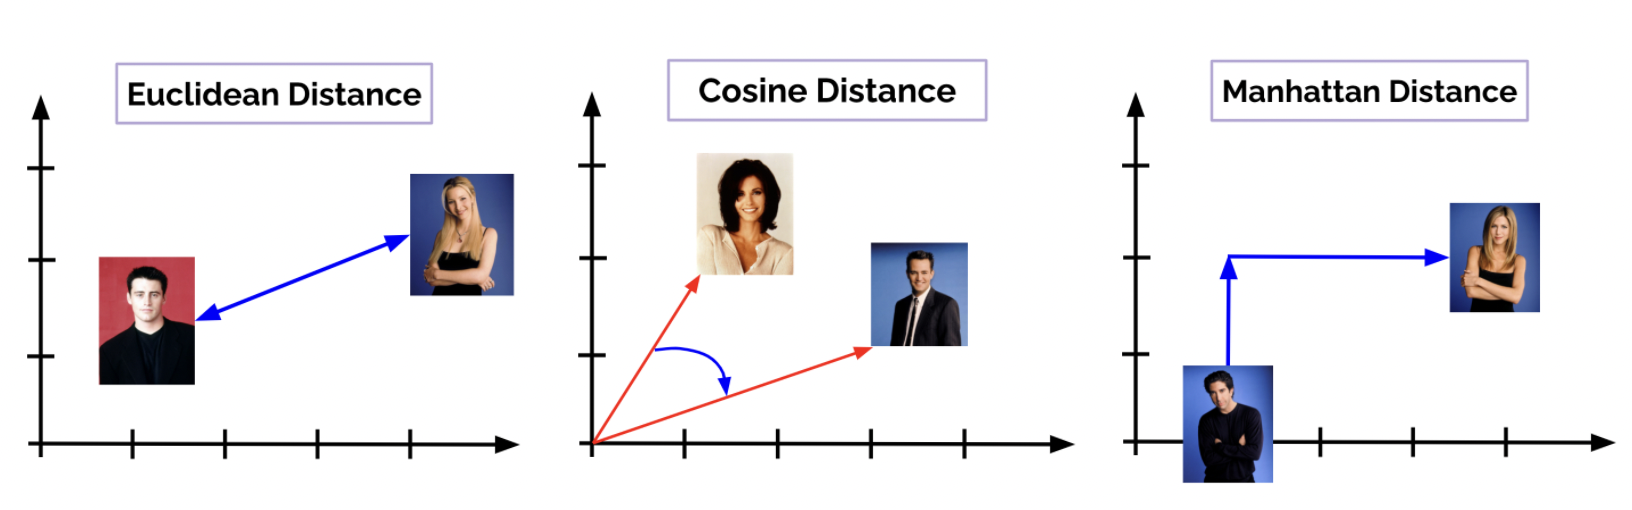

In [ ]:
def all_similarity(vectors, sim_metric='cosine'):
  if sim_metric == 'cosine':
    return cosine_similarity(vectors)
  else:
    # greater distance means the vectors are less similar, so we negate it
    return -pairwise_distances(vectors, metric=sim_metric)

In [ ]:
# YOUR CODE HERE
similarityMatrix = all_similarity(song_vectors)

In [ ]:
# YOUR CODE HERE
similarityMatrix.shape

(12112, 12112)

In [ ]:
def similarity_score(track1, track2, metric='cosine'):
  if track1==None or track2==None:
    return None


  # YOUR CODE HERE (get rid of the score=0 line)
  index1 = find_index_from_title(track1)
  index2 = find_index_from_title(track2)

  score = similarityMatrix[index1][index2]
  return score

In [ ]:
song_1 = widgets.Combobox(
    placeholder='Choose a Song',
    options=available_songs,
    description='song1:',
    ensure_option=True,
    disabled=False)
song_1

Combobox(value='', description='song1:', ensure_option=True, options=('Party In The U.S.A., Miley Cyrus', 'The…

In [ ]:
song_2 = widgets.Combobox(
    placeholder='Choose a Song',
    options=available_songs,
    description='song2:',
    ensure_option=True,
    disabled=False)
song_2

Combobox(value='', description='song2:', ensure_option=True, options=('Party In The U.S.A., Miley Cyrus', 'The…

In [ ]:
#@title Run this to process your song choices!
if song_1.value!='' and song_2.value!='':
  song1 = music_data['track_name'][available_songs.index(song_1.value)]
  song2 = music_data['track_name'][available_songs.index(song_2.value)]

In [ ]:

print(similarity_score(song1, song2))

0.674631420372692


In [ ]:
numerical_features = [] # YOUR CODE HERE
text_features = [] # YOUR CODE HERE

In [ ]:
# gets rid of null values
if 'genres' in text_features:
  music_data['genres'] = music_data['genres'].fillna('')
  music_data['genres'] = music_data.apply(fix_genres, axis=1)
for feature in text_features:
    music_data[feature] = music_data[feature].fillna('')
music_data["combined_features"] = music_data.apply(combine_features,axis=1)

# Make the combined vector out of text features
cv = CountVectorizer()
count_matrix = cv.fit_transform(music_data["combined_features"]) # creates a vector out of our combined features

# Adds numerical features to vector
text_vectors = count_matrix.toarray()
numerical = music_data[numerical_features].to_numpy()
# Next line scales numerical values so features like track_popularity and tempo don't outweigh everything else!
numerical = (numerical - numerical.min(axis=0)) / (numerical.max(axis=0) - numerical.min(axis=0))
song_vectors = np.concatenate((text_vectors, numerical), axis=1)

ValueError: ignored

In [ ]:
song = 'Party In The U.S.A.'
song = 'Party In The U.S.A.'

similarity_matrix = all_similarity(song_vectors)
song_index = find_index_from_title(song)
song_similarity = similarity_matrix[song_index]

In [ ]:
K = 5

# using a loop
song_indices = []

for i in range(0, K):
  current_max = 0
  current_index = None
  for j in range(len(song_similarity)):
    if song_similarity[j] > current_max and j not in song_indices and j != song_index:
      current_max = song_similarity[j]
      current_index = j
  song_indices.append(current_index)

# using sorting
similar_songs = list(enumerate(song_similarity))
sorted_similar_songs = sorted(similar_songs,key=lambda x:x[1],reverse=True)[1:]
song_indices = [x[0] for x in sorted_similar_songs[:K]]


In [ ]:
song_names = []
singers = []

for index in song_indices:
  song_names.append(find_title_from_index(index))
  singers.append(find_artist_from_index(index))

In [ ]:
def k_most_similar_songs(song, song_vectors, K):
  similarity_matrix = all_similarity(song_vectors)
  song_index = find_index_from_title(song)
  song_similarity = similarity_matrix[song_index]

  song_indices = []

  for i in range(0, K):
    current_max = 0
    current_index = None
    for j in range(len(song_similarity)):
      if song_similarity[j] > current_max and j not in song_indices and j != song_index:
        current_max = song_similarity[j]
        current_index = j
    song_indices.append(current_index)

  song_names = []
  singers = []
  for index in song_indices:
    song_names.append(find_title_from_index(index))
    singers.append(find_artist_from_index(index))
  return song_names, singers


In [ ]:
#@title Run this to choose a song
song = widgets.Combobox(
    placeholder='Choose a Song',
    options=available_songs,
    description='Song:',
    ensure_option=True,
    disabled=False)
song

In [ ]:
# Run this to get your recommended songs!
song_name = music_data['track_name'][available_songs.index(song.value)]
similar_songs, similar_artists = k_most_similar_songs(song_name, song_vectors, 10)
print(similar_songs)
print(similar_artists)

In [ ]:
print("Setting up Streamlit...")
#print("Don't worry if you see ERROR here!")
!pip -q install streamlit
!pip -q install pyngrok
from pyngrok import ngrok

!wget 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Music%20Recommendation/data_with_most_lyrics.csv'
!wget 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Music%20Recommendation/spotify_data_urls.csv'

def launch_website():
  print ("Click this link to try your web app:")
  print ("If you get an error, wait 5 seconds and click again!")
  if (ngrok.get_tunnels() != None):
    ngrok.kill()
  public_url = ngrok.connect()
  print (public_url)
  !streamlit run --server.port 80 app.py >/dev/null

print("Done!")


In [ ]:
!ngrok authtoken 2RLqzRtQrAinzYhEmDEMeyiG7iv_4n7apDqsGVX5JadTPwasF

In [ ]:
%%writefile contentbased.py
import streamlit as st
import streamlit.components.v1 as components
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Music data
music_data = pd.read_csv('data_with_most_lyrics.csv')
music_data = music_data.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
music_data['lyrics'] = music_data['lyrics'].str.replace('\n', ' ')
available_songs = music_data["track_name"] + ', ' + music_data["artist_name"]
available_songs = available_songs.tolist()

# Past music data
past_data = pd.read_csv('spotify_data_urls.csv')

def find_title_from_index(index):
    return music_data["track_name"][index]
def find_artist_from_index(index):
    return music_data["artist_name"][index]
def find_index_from_title(track_name):
    return music_data.index[music_data.track_name == track_name].values[0]
# end imports

def k_most_similar_songs(song, song_vectors, K):
  similarity_matrix = all_similarity(song_vectors)
  song_index = find_index_from_title(song)
  song_similarity = similarity_matrix[song_index]

  song_indices = []
  for i in range(0, K):
    current_max = 0
    current_index = None
    for j in range(len(song_similarity)):
      if song_similarity[j] > current_max and j not in song_indices and j != song_index:
        current_max = song_similarity[j]
        current_index = j
    song_indices.append(current_index)

  song_names = []
  singers = []
  for index in song_indices:
    song_names.append(find_title_from_index(index))
    singers.append(find_artist_from_index(index))
  return song_names, singers


def combine_features(row, text_features=[]):
    combined_row = ''
    for feature in text_features:
      combined_row += str(row[feature])
      combined_row += ' '
    return combined_row[:-1]

def data_formatting(text_features, numerical_features):
  if 'genres' in text_features:
    music_data['genres'] = music_data['genres'].fillna('')
    # music_data['genres'] = music_data.apply(fix_genres, axis=1)
  for feature in text_features:
      music_data[feature] = music_data[feature].fillna('')
  music_data["combined_features"] = music_data.apply(lambda row: combine_features(row, text_features=text_features),axis=1)

  cv = CountVectorizer()
  count_matrix = cv.fit_transform(music_data["combined_features"]) # creates a vector out of our combined features

  text_vectors = count_matrix.toarray()
  numerical = music_data[numerical_features].to_numpy()
  song_vectors = np.concatenate((text_vectors, numerical), axis=1)
  return song_vectors


def all_similarity(vectors, sim_metric='cosine'):
  if sim_metric == 'cosine':
    return cosine_similarity(vectors)
  else:
    # greater distance means the vectors are less similar, so we negate it
    return -pairwise_distances(vectors, metric=sim_metric)

In [ ]:
%%writefile app.py
import streamlit as st
import streamlit.components.v1 as components

import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
from header import *
from response import *
from helper import *
from contentbased import *

create_header()

def get_song_recs(rec_method, text_features, numerical_features, song, genre, K):
  if rec_method == "Popular Songs":
    return top_song_recs(genre, K)
  elif rec_method == "Predicted Top Hits":
    return top_song_recs(genre, K, method='hit_prediction')
  else:
    if song is not None and song is not []:
      song_vectors = data_formatting(text_features, numerical_features)
      return k_most_similar_songs(song, song_vectors, K)
    return None, None


choice = st.radio("Choose recommendation method: ", ["Popular Songs", "Predicted Top Hits", "Content-Based Recommendation"])
if choice == "Content-Based Recommendation":
  left_column, m1, m2 = st.columns((1,1,1))
  with left_column:
    k = st.slider("Pick a value for K", 1, 20)

  genre = None
  with m1:
    avail_text_feat = ['artist_name', 'track_name', 'album', 'genres', 'lyrics']
    text_features = st.multiselect("Pick your text features!", avail_text_feat)
  with m2:
    avail_num_feat = ['track_popularity', 'year', 'artist_popularity', 'artist_followers', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness','acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo','duration_ms', 'time_signature']
    numerical_features = st.multiselect("Pick your numerical features!", avail_num_feat)

  select = st.multiselect("Pick a song!", available_songs, default = None)
  if select == []:
    song = None
  else:
    song = music_data['track_name'][available_songs.index(select[0])]
else:
  left_column, right_column = st.columns(2)
  with left_column:
    k = st.slider("Pick how many songs you want to see!", 1, 20)
  with right_column:
    available_genres = separate_values('genres')['genres'].value_counts().index.tolist()
    select = st.multiselect("Pick a genre!", available_genres)
    if select == []:
      genre = None
    else:
      genre = select[0]
  song = None
  text_features, numerical_features = None, None

recs, artists = get_song_recs(choice, text_features, numerical_features, song, genre, k)
get_app_response(recs, artists)


In [ ]:
launch_website()

In [ ]:
#Your Streamlit Toolbox!

"""
#Write text
st.write("text")

#Title
st.title('title')

#Header
st.header('header')

#Slider
value = st.slider('variable')

#Table
st.table(dataframe) #use a Pandas DataFrame

#Bar Chart (Example)
chart_data = pd.DataFrame({"predictions": predictions}, index = class_names)
st.bar_chart(chart_data)

#Matplotlib Figure
st.pyplot(fig) #use a Matplotlib figure

#Image
st.image(image, caption='Image Caption')

#Button
pressed = st.button('Button Name')

#Checkbox
checked = st.checkbox('Checkbox Name')

#File Input
uploaded_file = st.file_uploader("Upload File")

if uploaded_file is not None:
    pass #Do something here!

"""